<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Regression-on-Probabilities" data-toc-modified-id="Regression-on-Probabilities-1">Regression on Probabilities</a></span></li><li><span><a href="#Issues-with-Linear-Regression-for-Probabilities" data-toc-modified-id="Issues-with-Linear-Regression-for-Probabilities-2">Issues with Linear Regression for Probabilities</a></span></li></ul></div>

In [112]:
# HIDDEN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
# HIDDEN
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]
    if len(df.columns) <= ncols:
        interact(peek, row=(0, len(df) - nrows, nrows), col=fixed(0))
    else:
        interact(peek,
                 row=(0, len(df) - nrows, nrows),
                 col=(0, len(df.columns) - ncols))
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

In [201]:
# HIDDEN
def jitter_df(df, x_col, y_col):
    x_jittered = df[x_col] + np.random.normal(scale=0, size=len(df))
    y_jittered = df[y_col] + np.random.normal(scale=0.05, size=len(df))
    return df.assign(**{x_col: x_jittered, y_col: y_jittered})

## Regression on Probabilities

In a popular sport called basketball, players score by shooting a ball through a hoop. One such player, LeBron James, is widely considered one of the best basketball players ever for his incredible ability to score.

<img src="https://upload.wikimedia.org/wikipedia/commons/4/4e/LeBron_James_%2831944491583%29.jpg" alt="LeBron James (31944491583).jpg" height="480" width="308">

LeBron plays in the National Basketball Association (NBA), the United States's premier basketball league. We've collected a dataset of all of LeBron's attempts in the 2017 NBA Playoff Games using the NBA statistics website (https://stats.nba.com/). 

In [148]:
lebron = pd.read_csv('lebron.csv')
lebron

,game_date,minute,opponent,action_type,shot_type,shot_distance,shot_made
0,20170415,10,IND,Driving Layup Shot,2PT Field Goal,0,0
1,20170415,11,IND,Driving Layup Shot,2PT Field Goal,0,1
2,20170415,14,IND,Layup Shot,2PT Field Goal,0,1
...,...,...,...,...,...,...,...
381,20170612,46,GSW,Driving Layup Shot,2PT Field Goal,1,1
382,20170612,47,GSW,Turnaround Fadeaway shot,2PT Field Goal,14,0
383,20170612,48,GSW,Driving Layup Shot,2PT Field Goal,2,1


This dataset contains one row containing the following attributes of every shot LeBron attempted:

- `game_date`: The date of the game played.
- `minute`: The minute that the shot was attempted (each NBA game is 48 minutes long).
- `opponent`: The team abbreviation of LeBron's opponent.
- `action_type`: The type of action leading up to the shot.
- `shot_type'`: The type of shot (either a 2 point shot or 3 point shot).
- `shot_distance`: The distance from the basket when shot was attempted.
- `shot_made`: `0` if the shot missed, `1` if the shot went in.

We would like to use this dataset to predict whether LeBron will make future shots. This is a *classification problem*; we predict a category, not a continuous number as we do in regression.

Nonetheless, we may reframe this classification problem as a type of regression problem by predicting the *probability* that a shot will go in. For example, we expect that the probability that LeBron makes a shot is lower when he is farther away from the basket.

We plot the shot attempts below, showing the distance from the basket on the x-axis and whether made the shot on the y-axis. We've jittered the points slightly on the y-axis to mitigate overplotting.

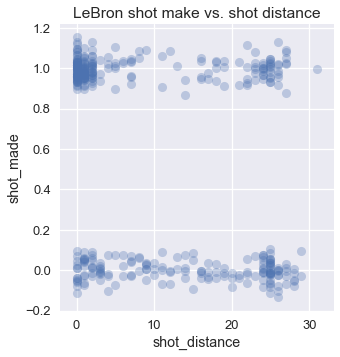

In [195]:
# HIDDEN
np.random.seed(42)
sns.lmplot(x='shot_distance', y='shot_made',
           data=jitter_df(lebron, 'shot_distance', 'shot_made'),
           fit_reg=False,
           scatter_kws={'alpha': 0.3})
plt.title('LeBron shot make vs. shot distance');

We can see that LeBron tends to make most shots when he is within five feet of the basket. A simple least squares linear regression model fit on this data produces the following predictions:

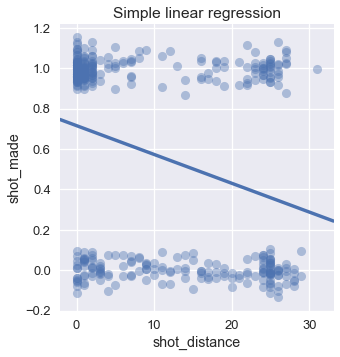

In [200]:
# HIDDEN
np.random.seed(42)
sns.lmplot(x='shot_distance', y='shot_made',
           data=jitter_df(lebron, 'shot_distance', 'shot_made'),
           ci=None,
           scatter_kws={'alpha': 0.4})
plt.title('Simple linear regression');

This regression predicts a continuous value. To perform classification, however, we need to convert this value into a category: a shot make or a miss. We can accomplish this by setting a cutoff. If the regression predicts a value greater than 0.5, we predict that the shot will make. Otherwise, we predict that the shot will miss.

We draw the cutoff below as a green dashed line. According to this cutoff, our model predicts that LeBron will make a shot if he is closer than 15 feet away from the basket.

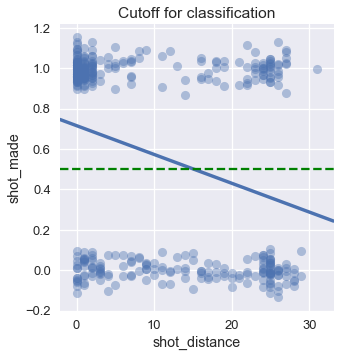

In [204]:
# HIDDEN
np.random.seed(42)
sns.lmplot(x='shot_distance', y='shot_made',
           data=jitter_df(lebron, 'shot_distance', 'shot_made'),
           ci=None,
           scatter_kws={'alpha': 0.4})
plt.axhline(y=0.5, linestyle='--', c='g')
plt.title('Cutoff for classification');

In the steps above, we attempt to perform a regression to predict the probability that a shot will go in. If our regression produces a probability, setting a cutoff of 0.5 means that we predict that a shot will go in when our model thinks the shot going in is more likely than the shot missing.

## Issues with Linear Regression for Probabilities

Unfortunately, our linear model's predictions cannot be interpreted as probabilities. Valid probabilities must lie between zero and one; our linear model violates this condition. For example, the probability that LeBron makes a shot when he is 100 feet away from the basket should be close to zero. In this case, however, our model will predict a negative value.

If we alter our regression model so that its predictions may be interpreted as probabilities, we have no qualms about using its predictions for classification. We accomplish this with a new prediction function and a new cost function. The resulting model is called a **logistic regression** model.